Задача по извлечению фич из ЭМГ.
Основная статья
https://www.researchgate.net/publication/325226027_Feature_Extraction_and_Selection_for_Myoelectric_Control_Based_on_Wearable_EMG_Sensors

1. Фичи, харктеризующие мощность и амплитуду сигнала

    Integrated Absolute Value IAV
    
    Mean Absolute Value MAV
    
    Root Mean Square RMS
    
    Variance VAR
    
    Waveform Length WL
    
    Log Detector LD
    
    Difference Absolute Mean Value DAMV
    
    Differebce Absolute Standard Deviation Value DASDV
    
    Differebce Variance Value DVARV
    
    Mean Value of Square Root MSR
    
    L-scale LS 

2. Фичи, характеризующие нелинейность и частотную информацию

    Maximum Fractal Length MFL
    
    https://www.mdpi.com/2079-3197/7/1/12/htm
    
    Detrended fluctuation analysis DFA
    
    Sample Entropy SampEn
    
    Zero Crossing ZC
    
    Slope Sign Change SSC
    
    Willison Amplitude WAMP
    
    Median Frequency MDF
    
    Mean Frequency MNF
    
3. Фичи, использующие ЭМГ как временные ряды

    Autoregressive Coefficients AR
    
    Cepstrum Coefficients CC
    
    Разного порядка 4 6 9
   
4. Уникальные

    HIST - расширение ZC и WAMP 9 data bins
    
Предложенные группы фичей
1. MAV WL ZC SSC
2. RMS AR6
3. MAV WL ZC SSC RMS AR6
4. AR4 HIST9
5. WL LD SSC AR9
6. WL SSC AR9 CC9
7. RMS VAR LD HIST9
8. WL RMS SampEn CC4

Датасеты ninaPro

Для экспериментов используем датасет ninaPro с характеристиками:

40 человек, оборудование Delsys, 17 классов движений, повторение 6 раз, частота 2000 Гц

In [2]:
import numpy as np

In [60]:
def from_mat_to_numpy(data):
    """
    Функция для формирования датасета в виде, который можно скормить классификатору.
    
    data - словарь, полученный в результате чтения .mat файла. Ключи в нём - названия, значения - значения в виде numpy массивов.
    Интересующие нас:
        emg - сигнал
        stimulus - номер выполняемого движения
        repetition - номер повтора движения
        
    Сигнал, соотв. одному и тому же повторению и движению, склеиваем в один. И сопоставляем соотв.номер движения и повторения.
    Пропускаем моменты отдыха (движение 0).
    И ещё обрезаем до одинаковой длины 5с или 12*10000 значений.
    """
    #Длина желаемой ЭМГ в секундах
    EMG_LEN = 5
    #Частота записи ЭМГ в Гц
    EMG_RATE = 2000
    #Количество каналов при записи
    EMG_CHANNELS = 12
    emg = data['emg']
    target = data['stimulus']
    repetition = data['repetition']
    
    n = emg.shape[0]
    
    curr_target = 0
    curr_rep = 0
    current_emg = np.array([])
    preprocess_data = np.zeros(shape=(17*6, EMG_LEN*EMG_RATE*EMG_CHANNELS + 2))
    index = 0
    for i in range(n):
        if target[i][0] == curr_target and repetition[i][0] == curr_rep:
            if curr_target != 0 and curr_rep != 0:
                current_emg = np.append(current_emg, emg[i])
        else:
            if curr_target != 0 and curr_rep != 0:
                diff = current_emg.shape[0] - EMG_RATE*EMG_LEN*EMG_CHANNELS
                if diff > 0:
                    begin = diff//2   
                    end = current_emg.shape[0] - diff + begin
                current_emg = current_emg[begin:end]    
                current_emg = np.append(current_emg, curr_target)
                current_emg = np.append(current_emg, curr_rep)
                preprocess_data[index] = current_emg
                index += 1
            curr_target = target[i][0]
            curr_rep = repetition[i][0]
            current_emg = emg[i]
    return preprocess_data

In [62]:
#Скрипт для обработки данных
#Проходимся по папкам с датасетом, открываем файлы, обрабатываем в нужный вид и сохраняем все npy.
def process_mat_files(path):
    file_name = "/DB2_s{n:d}/S{n:d}_E1_A1.mat"
    #processed_file_name = "/processed/S{n:d}_E1_A1"
    file_path = path + file_name
    processed_files = from_mat_to_numpy(scipy.io.loadmat(file_path.format(n=1)))
    for i in range(2, 41):
        current_file_path = file_path.format(n=i)
        current_file = scipy.io.loadmat(current_file_path)
        processed_files = np.concatenate((processed_files, from_mat_to_numpy(current_file)), axis=0)
        print(i)
    np.save(path + '/dataset', processed_files)

In [ ]:
process_mat_files("data/ninaPro/DB2")

In [63]:
from scipy import signal

In [64]:
#Реализация фильтров для ЭМГ
def notch(data, val = 50, fs = 2000):
    notch_freq_Hz = np.array([float(val)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), 'bandstop')
        fin = data = signal.lfilter(b, a, data)
    return fin
    
def bandpass(data, start = 5, stop = 999, fs = 2000):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(5, bp_Hz / (fs / 2.0), btype='bandpass')
    return signal.lfilter(b, a, data, axis=0)

In [65]:
#Реализация фичей
import math

def integrated_absolute_value(segment):
    """
    Функция вычисления фичи IAV для конкретного сегмента.
    Площадь под кривой ЭМГ (мощность)
    """
    return sum([abs(s) for s in segment])

def mean_absolute_value(segment):
    """
    Функция вычисления фичи MAV для конкретного сегмента.
    Среднее значение сигнала по модулю.
    """
    return sum([abs(s) for s in segment])/len(segment)

def waveform_length(segment):
    """
    Функция вычисления фичи WL для конкретного сегмента.
    Суммарная длина сигнала. Сумма разностей соседних значений.
    """
    n = len(segment)
    wl = 0
    for i in range(1, n):
        wl += abs(segment[i] - segment[i-1])
    return wl

def zero_crossing(segment):
    """
    Функция вычисления фичи ZC для конкретного сегмента.
    Количество раз, когда сигнал пересекает ноль. Частотная информация.
    """
    #Можно задать e - погрешность на шумы и добавить условие |x_k - x_(k+1)| >= e.
    n = len(segment)
    zc = 0
    for i in range(n - 1):
        if segment[i] * segment[i+1] < 0:
            zc += 1
    return zc

def slope_sign_changes(segment):
    """
    Функция вычисления фичи SSC для конкретного сегмента. 
    Количество раз, когда сигнал меняет возрастание/убывание.
    Как и ZC выделяет частотную информацию. 
    """
    n = len(segment)
    ssc = 0
    for i in range(1, n-1):
        if segment[i-1] < segment[i] and segment[i] > segment[i+1] or segment[i-1] > segment[i] and segment[i] < segment[i+1]:
            ssc += 1
    return ssc

def root_mean_square(segment):
    """
    Функция вычисления фичи RMS для конкретного сегмента. 
    """
    return math.sqrt(sum([s*s for s in segment])/len(segment))

In [103]:
"""
Реализация фичи AR. Autoregressive coefficients.
Для нее не нужно выделение окон. 
Вычисляет для каждого канала коэффициенты авторегрессии. Их количество соотв. порядку регрессии order.
Для вычисления используем библиотеку nitime
"""
from nitime.algorithms.autoregressive import AR_est_LD
from sklearn.preprocessing import StandardScaler

def autoregression_coefficients(emg, order, n_channels):
    n, m = emg.shape
    scaler = StandardScaler()
    emg = scaler.fit_transform(emg)
    X = [[] for _ in range(n)]
    for i in range(n):
        for channel in range(n_channels):
            s = emg[i][channel::n_channels] 
            coef = AR_est_LD(s, order=order)[0]
            X[i].extend(coef)
    return np.array(X)

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
class random_feature_exctraction:
    """
    Класс для извлечения фичей из ЭМГ.
    Fields: 
        rate - частота ЭМГ в Гц, 
        window_size - ширина окна, по которому вычисляется фича, в мс
        n_channels - количество каналов ЭМГ
        window_begin - индекс начала окна
        features_list - список фичей, которые хотим извлечь
    """
    def __init__(self, rate, window_size, n_channels, window_begin, features_list):
        self.rate = rate
        self.window_len = int(self.rate/1000*window_size)  # Соотв. длина окна для одного канала
        self.n_channels = n_channels
        self.features_list = features_list
        self.window_begin = window_begin
    
    def exctract(self, emg):
        """
        Извлекает фичи из features_list для каждого канала из окна размера window_size с началом window_begin.
        Parameters:
            emg - numpy array of size (number_of_samples, length_of_signal)
            One row of emg:
             channel_1_value_1 channel_2_value_1 ... channel_m_value_1 channel_1value_2 ...
        Return:
            numpy array with new features
            Each row of emg is processed:
             channel_1_feature_1 channel_1_feature2 ... channel_1_feature_n channel_2_feature_1 .... channel_m_feature_n

        """
        number_of_samples, signal_len = emg.shape
        X = [[] for _ in range(number_of_samples)]
        for j in range(number_of_samples):
            feature_vector = []
            #Для каждого канала
            for channel in range(self.n_channels):
                step = self.n_channels
                #Выделяем значения одного канала с учетом желаемой частоты
                channel_emg = emg[j][channel::step]
                # Для сегмента [window_begin:window_begin+window_len] вычисляем значения фичей и записываем их в вектор
                begin = self.window_begin
                end = begin + self.window_len
                segment = channel_emg[begin:end]
                for f in self.features_list:
                    feature_vector.append(f(segment))
            X[j] = feature_vector
        return np.array(X)

In [68]:
#Загрузим весь датасет
data = np.load('data/ninaPro/DB2/dataset.npy')
print(data.shape)

(4080, 120002)


In [69]:
#Возьмем пока 7 классов 1..7
n, m = data.shape
idx_to_del = []
classes = [1, 2, 3, 4, 5, 6, 7]
for i in range(n):
    if (data[i][120000] not in classes):
        idx_to_del.append(i)
data = np.delete(data, idx_to_del, axis=0)
print(data.shape)

(1680, 120002)


In [70]:
def filter_emg(X, rate):
    """
    Функция фильтрации ЭМГ сигнала X частоты rate.
    Фильтры применяем к каждому каналу в отдельности.
    """
    n, m = X.shape
    for i in range(n):
        X_filtered = X[i]
        X_filtered = np.reshape(X_filtered, (m//12, 12))
        X_filtered = np.apply_along_axis(notch, 0, X_filtered, fs=rate)
        X_filtered = np.apply_along_axis(bandpass, 0, X_filtered, start=5, stop=rate//2 - 1, fs=rate)
        X_filtered = np.reshape(X_filtered, (1, m))
        X[i] = X_filtered

In [71]:
import random

In [81]:
def exctract_and_save(emg, features_list, feature_set_num, N=100, n_step=1, window_size=100, rate=2000, emg_len=5000, n_channels=12):
    """
    Функция извлечения фичей из ЭМГ и сохранения файлов для различных значений n.
    emg - numpy array сигнала ЭМГ,
    features_list - список фичей(в виде функций), которые хотим извлечь
    feature_set_num - номер набора фичей
    N - максимальное количество окон, по которым считаем фичи
    n_step - шаг в количестве рассм. окон
    window_size - размер окна в мс,
    rate - частота эмг в Гц
    emg_len - длина всего сигнала ЭМГ в мс, 
    n_channels - количество каналов
    """
    max_idx = rate / 1000 * (emg_len - window_size)
    X_features = np.array([[] for _ in range(emg.shape[0])])
    filename = 'data/ninaPro/DB2/featureSet{fs_num:d}/X_{i:d}_{rate:d}'
    #Для воспроизводимости фиксируем seed
    random.seed(42)
    for i in range(1, N+1):
        n = random.randint(0, max_idx-1)
        extractor = random_feature_exctraction(
            rate=rate, 
            window_size=window_size, 
            n_channels=n_channels, 
            window_begin=n, 
            features_list=features_list)
        X_features = np.concatenate((X_features, extractor.exctract(emg)), axis=1)
        if (i%n_step == 0):
            np.save(filename.format(fs_num=feature_set_num, i=i, rate=rate), X_features)
        print(i)

In [73]:
#Формируем набор 2000 Гц и вектор классов
n = data.shape[1]
X_2000 = data[:, :n-2]
y = data[:, n-2]

In [112]:
#Формируем набор 1000 Гц
#Просто берем значения 12 через 12
m, n = X_2000.shape
X_1000 = np.zeros((m, n//2))
for i in range(m):
    row = X_2000[i]
    row = np.reshape(row, (n//12, 12))
    row = row[::2][:]
    row = np.reshape(row, (1, n//2))
    X_1000[i] = row
X_1000 = np.array(X_1000)
print(X_1000.shape)

(1680, 60000)


In [75]:
filter_emg(X_2000, rate=2000)

In [113]:
filter_emg(X_1000, rate=1000)

In [ ]:
featureSet1 = [mean_absolute_value, waveform_length, zero_crossing, slope_sign_changes]
exctract_and_save(emg=X_2000, features_list=featureSet1, N=100, feature_set_num=1)

In [ ]:
exctract_and_save(X_1000, featureSet1, 1, N=100, rate=1000)

In [84]:
#Зафиксируем количество классов
N_CLASSES = 7

In [85]:
#Разделим таргет на train/test. В тест запишем каждое 6 повторение
n = y.shape[0]
test_idx = range(5, n, 6)
y_train = np.delete(y, test_idx, axis=0)
y_test = y[test_idx]

In [86]:
print(y_train.shape)
print(y_test.shape)

(1400,)
(280,)


In [87]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [88]:
y_train = keras.utils.to_categorical(y_train - 1, num_classes=N_CLASSES)
y_test = keras.utils.to_categorical(y_test - 1, num_classes=N_CLASSES)

In [89]:
print(y_train.shape)
print(y_test.shape)

(1400, 7)
(280, 7)


In [90]:
def experiment(n, feature_set_num, rate):
    #Загружаем данные, соотв. n - количество извлечений фич из окон по 100 мс
    X = np.load('data/ninaPro/DB2/featureSet{num:d}/X_{n:d}_{r:d}.npy'.format(num=feature_set_num, n=n, r=rate))
    #Разобьем на train и test признаки аналогично таргету
    X_train = np.delete(X, test_idx, axis=0)
    X_test = X[test_idx][:]
    #Масштабируем фичи
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #Создание модели
    dim = X_train.shape[1]
    model = Sequential()
    model.add(Dense(36, activation='relu', input_dim=dim))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    #Обучение модели
    model.fit(X_train, y_train, epochs=150, batch_size=50)
    test_size = X_test.shape[0]
    score = model.evaluate(X_test, y_test, batch_size=test_size)
    
    #Возвращаем итоговую метрику на тесте
    return score[1]

In [97]:
#Создадим массивы для построения графиков
def arrays_for_plot(feature_set_n, rate, step):
    n_windows = list(range(1, 101, step))
    metrics = []
    for n in n_windows:
        acc = experiment(n, feature_set_n, rate=rate)
        metrics.append(acc)
    return n_windows, metrics

In [92]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\novon\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
x1_2000, y1_2000 = arrays_for_plot(feature_set_n=1, rate=2000)

In [ ]:
x1_1000, y1_1000 = arrays_for_plot(feature_set_n=1, rate=1000, step=5)

In [ ]:
#Извлечем из эмг фичу rms и ar, соединим и сохраним
#Для частоты 2000
featureSet2 = [root_mean_square]
exctract_and_save(emg=X_2000, features_list=featureSet2, N=100, feature_set_num=2)

In [117]:
AR6_2000 = autoregression_coefficients(X_2000, order=6, n_channels=12)

In [127]:
for n in range(1, 101):
    X = np.load('data/ninaPro/DB2/featureSet2/X_{n:d}_2000.npy'.format(n=n))
    X = np.concatenate((X, AR6_2000), axis=1)
    np.save('data/ninaPro/DB2/featureSet2/X_{n:d}_2000.npy'.format(n=n), X)

In [128]:
X = np.load('data/ninaPro/DB2/featureSet2/X_70_2000.npy'.format(n=n))
print(X.shape)

(1680, 912)


In [ ]:
#Для частоты 1000
exctract_and_save(emg=X_1000, features_list=featureSet2, N=100, feature_set_num=2, rate=1000)

In [130]:
AR6_1000 = autoregression_coefficients(X_1000, order=6, n_channels=12)

In [131]:
for n in range(1, 101):
    X = np.load('data/ninaPro/DB2/featureSet2/X_{n:d}_1000.npy'.format(n=n))
    X = np.concatenate((X, AR6_1000), axis=1)
    np.save('data/ninaPro/DB2/featureSet2/X_{n:d}_1000.npy'.format(n=n), X)

In [ ]:
x2_2000, y2_2000 = arrays_for_plot(feature_set_n=2, rate=2000, step=5)

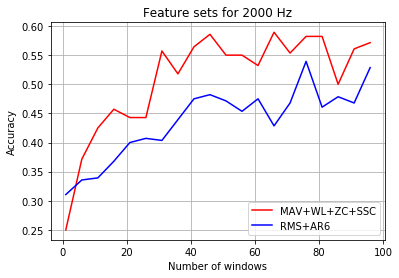

In [137]:
pylab.grid(True)
pylab.plot(x1_2000, y1_2000, 'r-', label='MAV+WL+ZC+SSC')
pylab.plot(x2_2000, y2_2000, 'b-', label='RMS+AR6')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')
pylab.legend(loc='lower right')
pylab.title('Feature sets for 2000 Hz')

In [ ]:
x2_1000, y2_1000 = arrays_for_plot(feature_set_n=2, rate=1000, step=5)

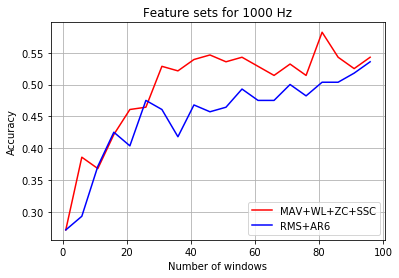

In [140]:
pylab.grid(True)
pylab.plot(x1_1000, y1_1000, 'r-', label='MAV+WL+ZC+SSC')
pylab.plot(x2_1000, y2_1000, 'b-', label='RMS+AR6')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')
pylab.legend(loc='lower right')
pylab.title('Feature sets for 1000 Hz')